# Tarea: Experimentación con Redes Neuronales Feed-Forward (MLP)
## curso machine learning(introducción a deep learning)

**Objetivo**: Explorar cómo diferentes hiperparámetros y arquitecturas afectan el desempeño de una red neuronal multicapa en el problema de clasificación de dígitos manuscritos (MNIST). Se usan los siguientes conceptos que aún no hemos visto en clase pero que son fáciles de interpretar:

* test-set: Datos que el modelo no ha recibido como entrada en su entrenamiento, son datos nunca antes vistos por lel modelo por lo que usarlos nos da una idea de como se comportará el modelo al ser usado para realizar predicciones en datos nuevos.
* underfitting: problema de calidad del modelo en el cual este no realiza predicciones correctas ni en los datos en los que se entrenó, ni en datos nuevos, es un modelo de baja calidad(puede ocurrir por entrenarse muy pocas iteraciones, por usar pocas capas, por usar pocas neuronas por capa etc). Se detecta por que las métricas de calidad como accurracy son muy bajas, o se tiene un error/costo/perdida muy alto tanto en los datos de entrenamiento como en los de test.
* overfitting: problema de calidad del modelo en el cual este realiza predicciones correctas en el set(datos) de entrenamiento pero al probarlo en nuevos datos nunca usados(test-set) este no genera buenas predicciones, se dice que el modelo "memorizó" en lugar de aprender y es capaz de "generalizar". Puede ocurrir por: tener muy pocos datos ,entrenarlo por muchas iteraciones(más de lo necesario), o una arquitectura muy compleja(muchas capas o muchas neuronas por capa). Se detecta por que las métricas de calidad como accurracy son altas en el set de entrenamiento, pero bajas en el test set o bien se tiene que el error/cost/loss es bajo en el set de entrenamiento pero alto en el test set.
* Dropout: técnica que ayuda a reducir el riesgo de overfitting a través de modificar la arquitectura de la red de forma que durante el entrenamiento algunas neuronas están desactivadas.
* Batch normalization: técnica que ayuda a estabilizar el entrenamiento, hacer que se converja mas rápido y también puede ayudar a reducir el overfitting en algunos casos, se basa en aplicar algunas transformaciones estadísticas a los datos de las capas intermedias/ocultas.

---

## Instrucciones Generales

En esta tarea trabajarás con el dataset MNIST y una arquitectura de red neuronal feed-forward (Multi-Layer Perceptron). El código base ya está implementado, tu trabajo consistirá en:

1. Ejecutar 10 experimentos modificando diferentes aspectos de la red
2. Analizar los resultados de cada experimento
3. Responder las preguntas específicas de cada ejercicio

**Entrega**: Completa todos los ejercicios en este notebook, ejecuta las celdas correspondientes, y responde las preguntas en las celdas de markdown proporcionadas.

---
## Configuración Inicial y Código Base

In [8]:
!pip install torch==2.9.1 torchvision==0.24.1


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [9]:
# Imports necesarios
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from time import time

# Configuración para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

# Verificar disponibilidad de GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

Usando dispositivo: cpu


In [10]:
# Cargar el dataset MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalización estándar para MNIST
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print(f'Tamaño del conjunto de entrenamiento: {len(train_dataset)}')
print(f'Tamaño del conjunto de prueba: {len(test_dataset)}')

Tamaño del conjunto de entrenamiento: 60000
Tamaño del conjunto de prueba: 10000


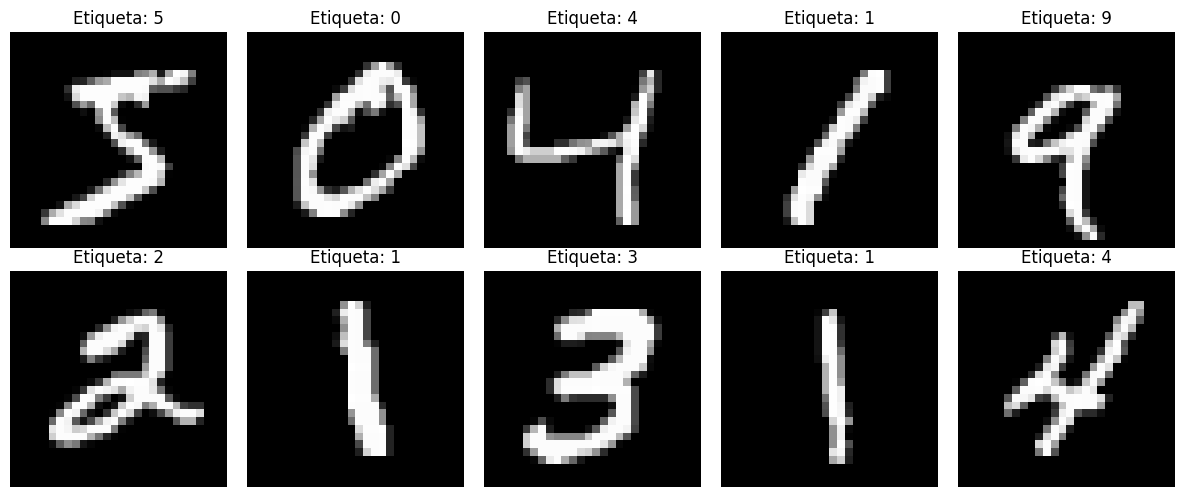

In [11]:
# Visualizar algunos ejemplos del dataset
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'Etiqueta: {label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

### Definición de la Red Neuronal Feed-Forward (MLP)

In [12]:
class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[128, 64], output_size=10, 
                 activation='relu', use_dropout=False, dropout_rate=0.5, use_batch_norm=False):
        """
        Multi-Layer Perceptron (MLP) flexible.
        
        Args:
            input_size: Tamaño de la entrada (28*28=784 para MNIST)
            hidden_sizes: Lista con el número de neuronas en cada capa oculta
            output_size: Número de clases (10 para MNIST)
            activation: Función de activación ('relu', 'tanh', 'sigmoid')
            use_dropout: Si se debe usar dropout
            dropout_rate: Tasa de dropout
            use_batch_norm: Si se debe usar batch normalization
        """
        super(MLP, self).__init__()
        
        # Seleccionar función de activación
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            raise ValueError(f'Activación no soportada: {activation}')
        
        # Construir capas
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(hidden_size))
            
            layers.append(self.activation)
            
            if use_dropout:
                layers.append(nn.Dropout(dropout_rate))
            
            prev_size = hidden_size
        
        # Capa de salida
        layers.append(nn.Linear(prev_size, output_size))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        # Aplanar la imagen de 28x28 a un vector de 784
        x = x.view(x.size(0), -1)
        return self.network(x)

print('Arquitectura MLP definida correctamente')

Arquitectura MLP definida correctamente


### Funciones de Entrenamiento y Evaluación

In [13]:
def train_model(model, train_loader, criterion, optimizer, device):
    """
    Entrena el modelo por una época.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Estadísticas
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc


def evaluate_model(model, test_loader, criterion, device):
    """
    Evalúa el modelo en el conjunto de prueba.
    """
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_loss = test_loss / len(test_loader)
    test_acc = 100 * correct / total
    
    return test_loss, test_acc


def run_experiment(model, train_loader, test_loader, criterion, optimizer, 
                   epochs, device, experiment_name="Experimento"):
    """
    Ejecuta un experimento completo de entrenamiento y evaluación.
    """
    print(f"\n{'='*60}")
    print(f"{experiment_name}")
    print(f"{'='*60}\n")
    
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    
    start_time = time()
    
    for epoch in range(epochs):
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        if (epoch + 1) % 2 == 0 or epoch == 0:
            print(f'Época [{epoch+1}/{epochs}] - '
                  f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - '
                  f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    
    training_time = time() - start_time
    
    print(f"\nTiempo total de entrenamiento: {training_time:.2f} segundos")
    print(f"Precisión final en test: {test_accs[-1]:.2f}%")
    
    # Graficar resultados
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.plot(train_losses, label='Train Loss', marker='o')
    ax1.plot(test_losses, label='Test Loss', marker='s')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Loss')
    ax1.set_title('Pérdida durante el Entrenamiento')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(train_accs, label='Train Accuracy', marker='o')
    ax2.plot(test_accs, label='Test Accuracy', marker='s')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Precisión (%)')
    ax2.set_title('Precisión durante el Entrenamiento')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs,
        'final_test_acc': test_accs[-1],
        'training_time': training_time
    }

print('Funciones de entrenamiento y evaluación definidas correctamente')

Funciones de entrenamiento y evaluación definidas correctamente


---
---
# EJERCICIOS

A continuación se presentan 10 ejercicios donde deberás modificar diferentes aspectos del modelo y analizar los resultados.

---
## Ejercicio 1: Modelo Baseline

**Objetivo**: Entrenar un modelo base con hiperparámetros estándar para establecer una línea de referencia.

**Configuración**:
- Arquitectura: [128, 64] (2 capas ocultas)
- Learning rate: 0.001
- Batch size: 64
- Épocas: 10
- Activación: ReLU
- Optimizador: Adam


Ejercicio 1: Modelo Baseline

Época [1/10] - Train Loss: 0.2645, Train Acc: 92.18% - Test Loss: 0.1499, Test Acc: 95.39%
Época [2/10] - Train Loss: 0.1114, Train Acc: 96.58% - Test Loss: 0.0994, Test Acc: 96.86%
Época [4/10] - Train Loss: 0.0609, Train Acc: 98.04% - Test Loss: 0.0818, Test Acc: 97.55%
Época [6/10] - Train Loss: 0.0386, Train Acc: 98.75% - Test Loss: 0.1023, Test Acc: 96.87%
Época [8/10] - Train Loss: 0.0297, Train Acc: 98.99% - Test Loss: 0.0824, Test Acc: 97.89%
Época [10/10] - Train Loss: 0.0224, Train Acc: 99.26% - Test Loss: 0.0984, Test Acc: 97.47%

Tiempo total de entrenamiento: 37.35 segundos
Precisión final en test: 97.47%


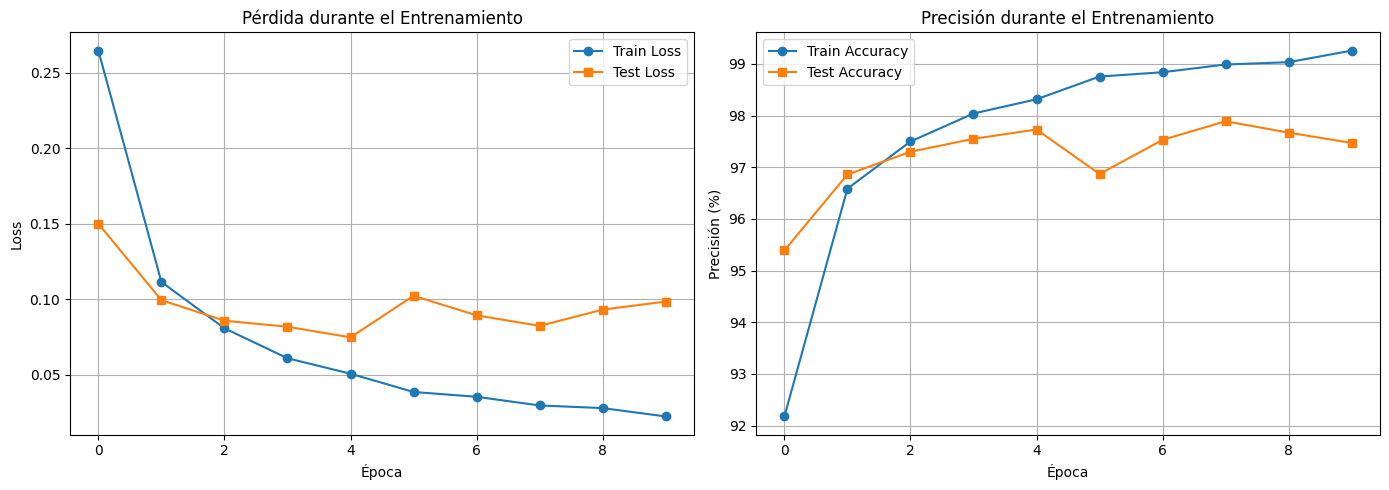

In [14]:
# Configuración del Ejercicio 1
batch_size = 64
learning_rate = 0.001
epochs = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = MLP(hidden_sizes=[128, 64], activation='relu').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

results_ex1 = run_experiment(model, train_loader, test_loader, criterion, optimizer, 
                             epochs, device, "Ejercicio 1: Modelo Baseline")

### Respuestas Ejercicio 1

**1.1** ¿Cuál fue la precisión final en el conjunto de test?

*Tu respuesta aquí*

**1.2** ¿Observas signos de overfitting o underfitting? Justifica tu respuesta basándote en las gráficas.

*Tu respuesta aquí*

---
## Ejercicio 2: Efecto del Learning Rate

**Objetivo**: Experimentar con un learning rate más alto (0.01) y analizar cómo afecta la convergencia.

**Modificación**: Cambia el learning rate de 0.001 a 0.01

**Pregunta**: ¿Cómo afecta un learning rate más alto al entrenamiento? ¿Es mejor o peor que el baseline?


Ejercicio 2: Learning Rate Alto (0.01)

Época [1/10] - Train Loss: 0.2772, Train Acc: 91.82% - Test Loss: 0.1848, Test Acc: 94.69%
Época [2/10] - Train Loss: 0.1861, Train Acc: 94.89% - Test Loss: 0.1700, Test Acc: 95.91%
Época [4/10] - Train Loss: 0.1538, Train Acc: 95.97% - Test Loss: 0.1547, Test Acc: 96.29%
Época [6/10] - Train Loss: 0.1447, Train Acc: 96.33% - Test Loss: 0.1692, Test Acc: 96.04%
Época [8/10] - Train Loss: 0.1414, Train Acc: 96.56% - Test Loss: 0.1666, Test Acc: 96.43%
Época [10/10] - Train Loss: 0.1246, Train Acc: 97.03% - Test Loss: 0.1739, Test Acc: 96.47%

Tiempo total de entrenamiento: 42.65 segundos
Precisión final en test: 96.47%


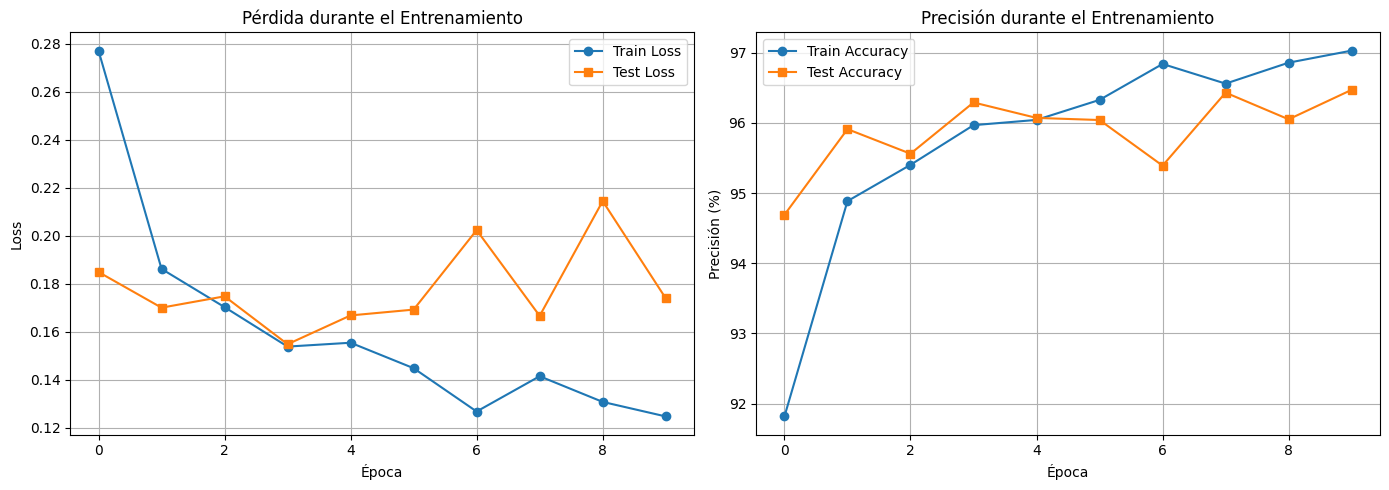

In [15]:
# Configuración del Ejercicio 2
batch_size = 64
learning_rate = 0.01  # MODIFICADO
epochs = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = MLP(hidden_sizes=[128, 64], activation='relu').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

results_ex2 = run_experiment(model, train_loader, test_loader, criterion, optimizer, 
                             epochs, device, "Ejercicio 2: Learning Rate Alto (0.01)")

### Respuestas Ejercicio 2

**2.1** Compara la precisión final con el Ejercicio 1. ¿Mejoró o empeoró?

*Tu respuesta aquí*

**2.2** ¿Cómo se ve la curva de loss? ¿Es más estable o más inestable que en el baseline?

*Tu respuesta aquí*

**2.3** ¿Qué puedes concluir sobre la elección del learning rate?

*Tu respuesta aquí*

---
## Ejercicio 3: Red más Profunda

**Objetivo**: Aumentar la profundidad de la red agregando más capas ocultas.

**Modificación**: Cambia la arquitectura de [128, 64] a [256, 128, 64, 32]

**Pregunta**: ¿Una red más profunda siempre es mejor? ¿Qué observas en términos de tiempo de entrenamiento y precisión?


Ejercicio 3: Red Más Profunda [256, 128, 64, 32]

Época [1/10] - Train Loss: 0.2969, Train Acc: 90.91% - Test Loss: 0.1221, Test Acc: 96.14%
Época [2/10] - Train Loss: 0.1100, Train Acc: 96.69% - Test Loss: 0.1037, Test Acc: 96.71%
Época [4/10] - Train Loss: 0.0584, Train Acc: 98.17% - Test Loss: 0.0854, Test Acc: 97.45%
Época [6/10] - Train Loss: 0.0411, Train Acc: 98.75% - Test Loss: 0.0735, Test Acc: 97.89%
Época [8/10] - Train Loss: 0.0325, Train Acc: 98.95% - Test Loss: 0.0796, Test Acc: 97.75%
Época [10/10] - Train Loss: 0.0248, Train Acc: 99.22% - Test Loss: 0.0967, Test Acc: 97.73%

Tiempo total de entrenamiento: 42.63 segundos
Precisión final en test: 97.73%


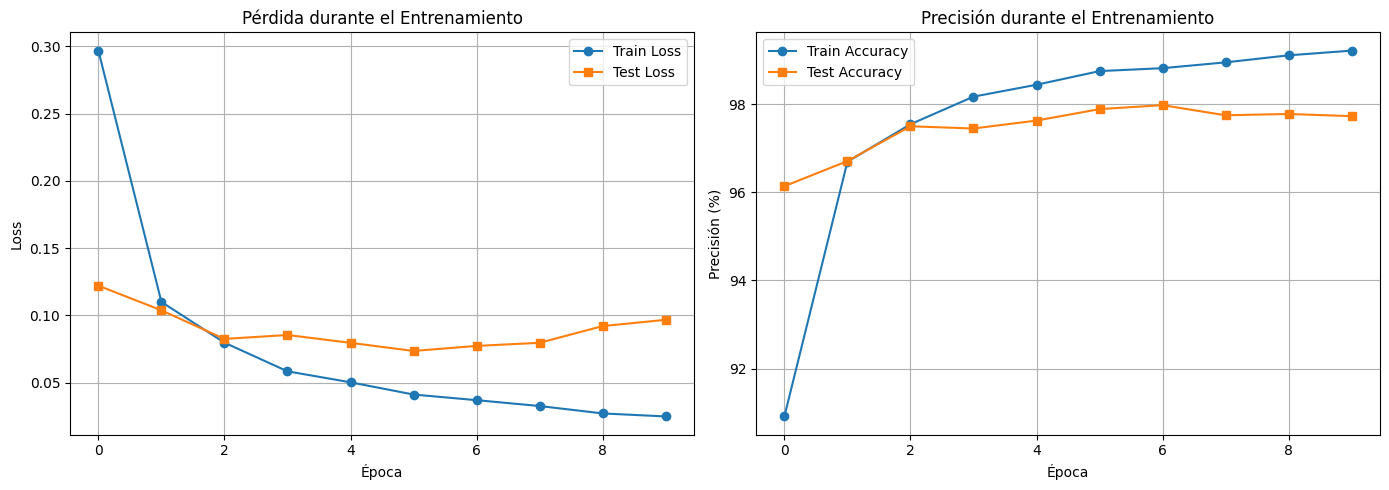

In [16]:
# Configuración del Ejercicio 3
batch_size = 64
learning_rate = 0.001
epochs = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = MLP(hidden_sizes=[256, 128, 64, 32], activation='relu').to(device)  # MODIFICADO
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

results_ex3 = run_experiment(model, train_loader, test_loader, criterion, optimizer, 
                             epochs, device, "Ejercicio 3: Red Más Profunda [256, 128, 64, 32]")

### Respuestas Ejercicio 3

**3.1** ¿Mejoró la precisión en test comparado con el baseline?

*Tu respuesta aquí*

**3.2** ¿Cuánto más tiempo tomó entrenar este modelo?

*Tu respuesta aquí*

**3.3** ¿Vale la pena el costo computacional adicional? Justifica.

*Tu respuesta aquí*

---
## Ejercicio 4: Batch Size Pequeño

**Objetivo**: Experimentar con un batch size más pequeño y observar el efecto en el entrenamiento.

**Modificación**: Cambia el batch size de 64 a 16

**Pregunta**: ¿Cómo afecta el tamaño del batch al proceso de entrenamiento y a la convergencia?


Ejercicio 4: Batch Size Pequeño (16)

Época [1/10] - Train Loss: 0.2207, Train Acc: 93.24% - Test Loss: 0.1413, Test Acc: 95.63%
Época [2/10] - Train Loss: 0.1070, Train Acc: 96.74% - Test Loss: 0.1103, Test Acc: 96.64%
Época [4/10] - Train Loss: 0.0637, Train Acc: 97.94% - Test Loss: 0.1091, Test Acc: 96.85%
Época [6/10] - Train Loss: 0.0437, Train Acc: 98.59% - Test Loss: 0.1049, Test Acc: 97.26%
Época [8/10] - Train Loss: 0.0388, Train Acc: 98.81% - Test Loss: 0.0985, Test Acc: 97.77%
Época [10/10] - Train Loss: 0.0313, Train Acc: 99.00% - Test Loss: 0.0973, Test Acc: 97.81%

Tiempo total de entrenamiento: 64.76 segundos
Precisión final en test: 97.81%


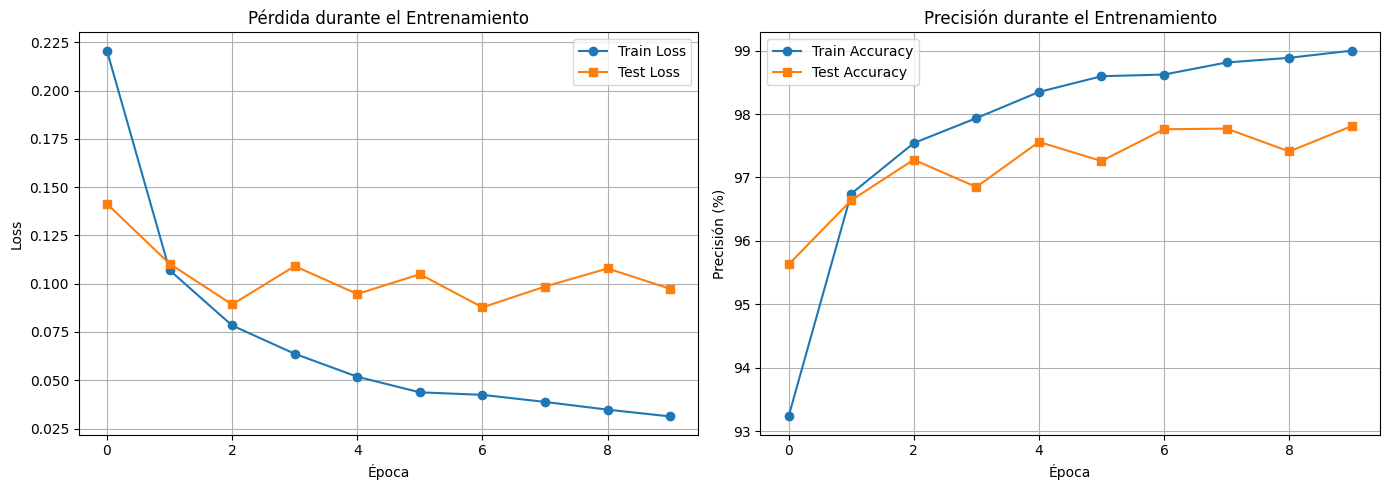

In [17]:
# Configuración del Ejercicio 4
batch_size = 16  # MODIFICADO
learning_rate = 0.001
epochs = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = MLP(hidden_sizes=[128, 64], activation='relu').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

results_ex4 = run_experiment(model, train_loader, test_loader, criterion, optimizer, 
                             epochs, device, "Ejercicio 4: Batch Size Pequeño (16)")

### Respuestas Ejercicio 4

**4.1** ¿Cómo se compara el tiempo de entrenamiento con el baseline?

*Tu respuesta aquí*

**4.2** ¿Las curvas de loss son más suaves o más ruidosas?

*Tu respuesta aquí*

**4.3** ¿Cuál es el trade-off entre batch size pequeño y grande?

*Tu respuesta aquí*

---
## Ejercicio 5: Función de Activación Tanh

**Objetivo**: Explorar el efecto de usar una función de activación diferente.

**Modificación**: Cambia la función de activación de ReLU a Tanh

**Pregunta**: ¿Cómo se desempeña Tanh comparado con ReLU para este problema?


Ejercicio 5: Activación Tanh

Época [1/10] - Train Loss: 0.2780, Train Acc: 92.28% - Test Loss: 0.1420, Test Acc: 95.72%
Época [2/10] - Train Loss: 0.1101, Train Acc: 96.77% - Test Loss: 0.1110, Test Acc: 96.45%
Época [4/10] - Train Loss: 0.0608, Train Acc: 98.12% - Test Loss: 0.1017, Test Acc: 96.81%
Época [6/10] - Train Loss: 0.0439, Train Acc: 98.66% - Test Loss: 0.0914, Test Acc: 97.15%
Época [8/10] - Train Loss: 0.0331, Train Acc: 98.91% - Test Loss: 0.0869, Test Acc: 97.35%
Época [10/10] - Train Loss: 0.0315, Train Acc: 98.95% - Test Loss: 0.1013, Test Acc: 97.10%

Tiempo total de entrenamiento: 38.52 segundos
Precisión final en test: 97.10%


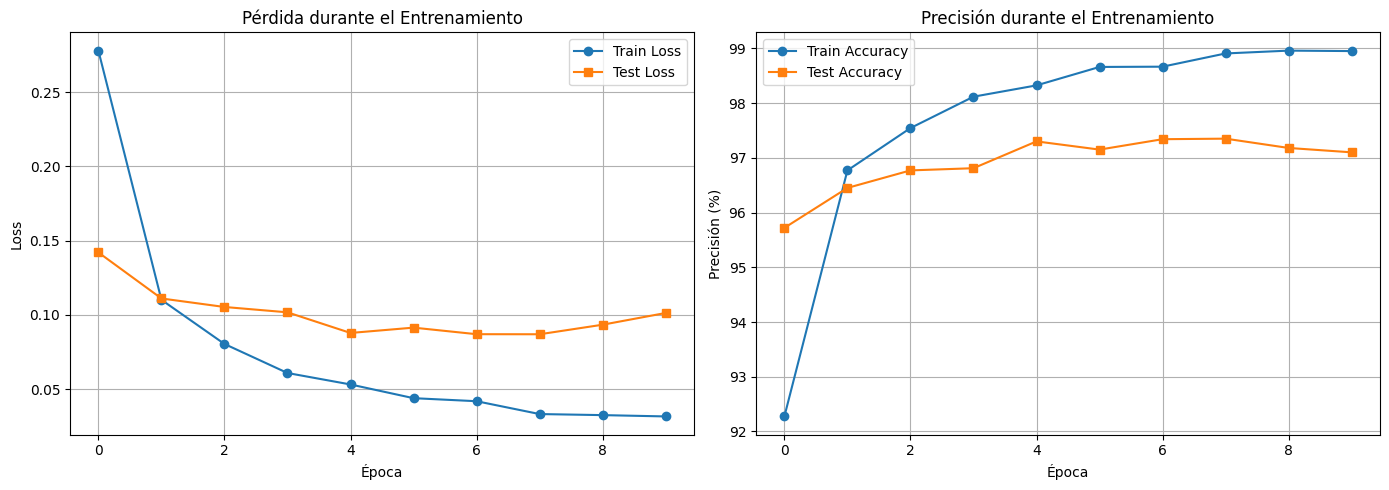

In [18]:
# Configuración del Ejercicio 5
batch_size = 64
learning_rate = 0.001
epochs = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = MLP(hidden_sizes=[128, 64], activation='tanh').to(device)  # MODIFICADO
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

results_ex5 = run_experiment(model, train_loader, test_loader, criterion, optimizer, 
                             epochs, device, "Ejercicio 5: Activación Tanh")

### Respuestas Ejercicio 5

**5.1** Compara la precisión final con el baseline (ReLU).

*Tu respuesta aquí*

**5.2** ¿Qué diferencias notas en la velocidad de convergencia?

*Tu respuesta aquí*

**5.3** ¿Por qué crees que ReLU es más popular en deep learning moderno?

*Tu respuesta aquí*

---
## Ejercicio 6: Agregar Dropout

**Objetivo**: Implementar regularización con Dropout para prevenir overfitting.

**Modificación**: Activa dropout con tasa de 0.5

**Pregunta**: ¿Cómo ayuda el dropout a mejorar la generalización del modelo?


Ejercicio 6: Con Dropout (0.5)

Época [1/10] - Train Loss: 0.5744, Train Acc: 82.67% - Test Loss: 0.2064, Test Acc: 93.90%
Época [2/10] - Train Loss: 0.3349, Train Acc: 90.54% - Test Loss: 0.1573, Test Acc: 95.52%
Época [4/10] - Train Loss: 0.2628, Train Acc: 92.58% - Test Loss: 0.1321, Test Acc: 96.16%
Época [6/10] - Train Loss: 0.2351, Train Acc: 93.32% - Test Loss: 0.1255, Test Acc: 96.53%
Época [8/10] - Train Loss: 0.2172, Train Acc: 93.75% - Test Loss: 0.1132, Test Acc: 96.68%
Época [10/10] - Train Loss: 0.2039, Train Acc: 94.24% - Test Loss: 0.1085, Test Acc: 96.82%

Tiempo total de entrenamiento: 41.16 segundos
Precisión final en test: 96.82%


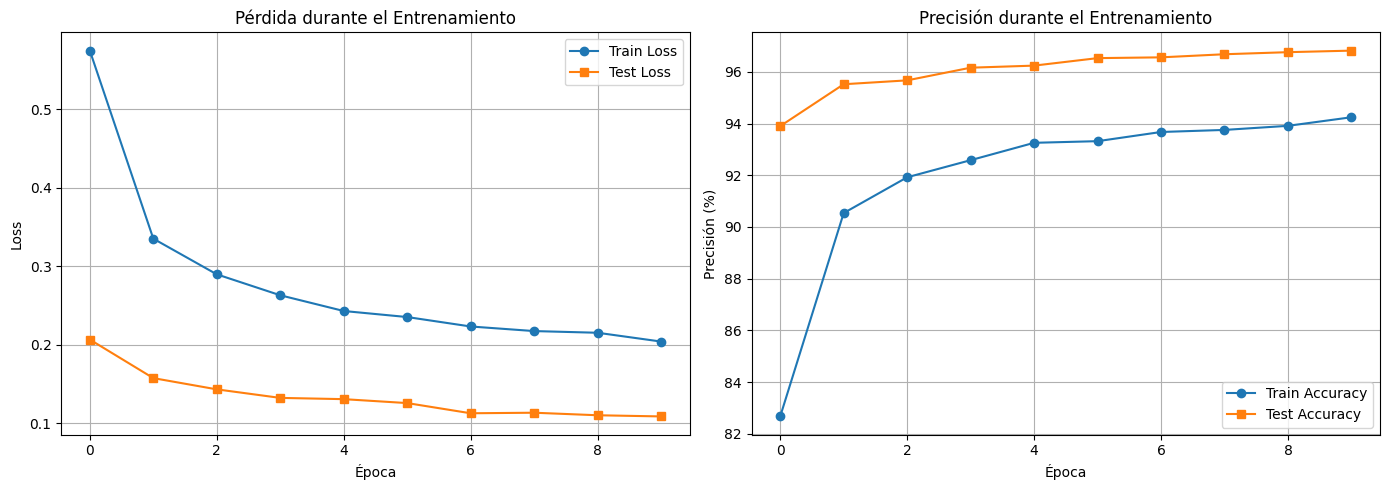

In [19]:
# Configuración del Ejercicio 6
batch_size = 64
learning_rate = 0.001
epochs = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = MLP(hidden_sizes=[128, 64], activation='relu', 
            use_dropout=True, dropout_rate=0.5).to(device)  # MODIFICADO
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

results_ex6 = run_experiment(model, train_loader, test_loader, criterion, optimizer, 
                             epochs, device, "Ejercicio 6: Con Dropout (0.5)")

### Respuestas Ejercicio 6

**6.1** ¿La brecha entre train accuracy y test accuracy se redujo?

*Tu respuesta aquí*

**6.2** ¿Cómo afectó el dropout a la precisión en training?

*Tu respuesta aquí*

**6.3** ¿En qué situaciones recomendarías usar dropout?

*Tu respuesta aquí*

---
## Ejercicio 7: Batch Normalization

**Objetivo**: Explorar el efecto de Batch Normalization en la estabilidad y velocidad del entrenamiento.

**Modificación**: Activa batch normalization

**Pregunta**: ¿Cómo mejora Batch Normalization el proceso de entrenamiento?


Ejercicio 7: Con Batch Normalization

Época [1/10] - Train Loss: 0.2532, Train Acc: 93.66% - Test Loss: 0.0972, Test Acc: 97.01%
Época [2/10] - Train Loss: 0.0934, Train Acc: 97.17% - Test Loss: 0.0880, Test Acc: 97.41%
Época [4/10] - Train Loss: 0.0517, Train Acc: 98.38% - Test Loss: 0.0720, Test Acc: 97.91%
Época [6/10] - Train Loss: 0.0348, Train Acc: 98.87% - Test Loss: 0.0700, Test Acc: 97.86%
Época [8/10] - Train Loss: 0.0291, Train Acc: 98.99% - Test Loss: 0.0742, Test Acc: 97.86%
Época [10/10] - Train Loss: 0.0227, Train Acc: 99.24% - Test Loss: 0.0666, Test Acc: 98.04%

Tiempo total de entrenamiento: 39.00 segundos
Precisión final en test: 98.04%


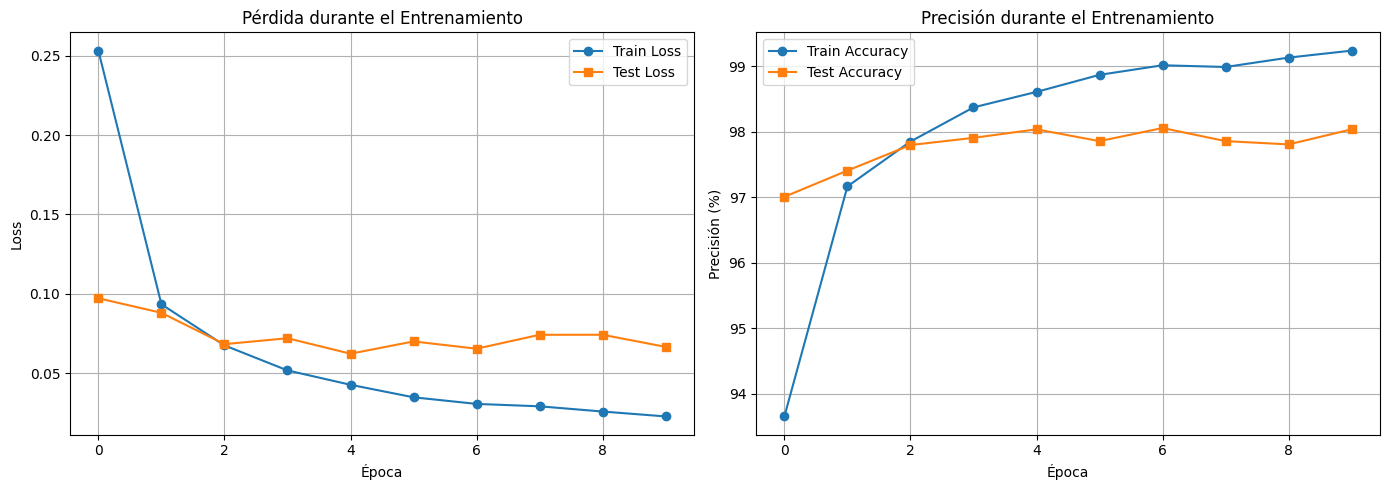

In [20]:
# Configuración del Ejercicio 7
batch_size = 64
learning_rate = 0.001
epochs = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = MLP(hidden_sizes=[128, 64], activation='relu', 
            use_batch_norm=True).to(device)  # MODIFICADO
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

results_ex7 = run_experiment(model, train_loader, test_loader, criterion, optimizer, 
                             epochs, device, "Ejercicio 7: Con Batch Normalization")

### Respuestas Ejercicio 7

**7.1** ¿Observas una convergencia más rápida con Batch Normalization?

*Tu respuesta aquí*

**7.2** ¿Mejoró la precisión final comparada con el baseline?

*Tu respuesta aquí*

**7.3** ¿Cuál es el principal beneficio de usar Batch Normalization?

*Tu respuesta aquí*

---
## Ejercicio 8: Red Más Ancha

**Objetivo**: Experimentar con una arquitectura más ancha en lugar de más profunda.

**Modificación**: Cambia la arquitectura de [128, 64] a [512, 256]

**Pregunta**: ¿Es mejor tener una red ancha o una red profunda? ¿Por qué?


Ejercicio 8: Red Más Ancha [512, 256]

Época [1/10] - Train Loss: 0.2038, Train Acc: 93.74% - Test Loss: 0.0959, Test Acc: 97.05%
Época [2/10] - Train Loss: 0.0860, Train Acc: 97.37% - Test Loss: 0.0835, Test Acc: 97.58%
Época [4/10] - Train Loss: 0.0461, Train Acc: 98.54% - Test Loss: 0.0756, Test Acc: 97.75%
Época [6/10] - Train Loss: 0.0345, Train Acc: 98.92% - Test Loss: 0.0697, Test Acc: 98.11%
Época [8/10] - Train Loss: 0.0267, Train Acc: 99.10% - Test Loss: 0.0791, Test Acc: 98.10%
Época [10/10] - Train Loss: 0.0228, Train Acc: 99.24% - Test Loss: 0.1038, Test Acc: 97.65%

Tiempo total de entrenamiento: 47.60 segundos
Precisión final en test: 97.65%


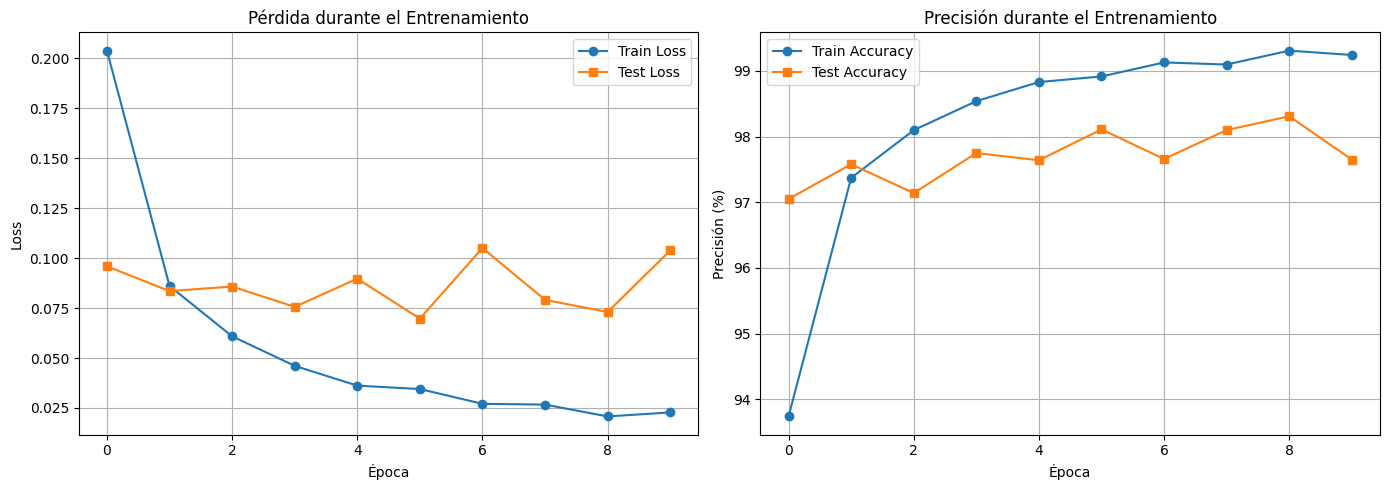

In [21]:
# Configuración del Ejercicio 8
batch_size = 64
learning_rate = 0.001
epochs = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = MLP(hidden_sizes=[512, 256], activation='relu').to(device)  # MODIFICADO
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

results_ex8 = run_experiment(model, train_loader, test_loader, criterion, optimizer, 
                             epochs, device, "Ejercicio 8: Red Más Ancha [512, 256]")

### Respuestas Ejercicio 8

**8.1** Compara los resultados con el Ejercicio 3 (red más profunda).

*Tu respuesta aquí*

**8.2** ¿Cuál tiene mejor desempeño: red ancha o red profunda?

*Tu respuesta aquí*

**8.3** ¿Qué principio puedes extraer sobre el diseño de arquitecturas?

*Tu respuesta aquí*

---
## Ejercicio 9: Optimizador SGD

**Objetivo**: Comparar el optimizador Adam con SGD (Stochastic Gradient Descent).

**Modificación**: Cambia el optimizador de Adam a SGD con momentum=0.9

**Pregunta**: ¿Cuáles son las diferencias prácticas entre Adam y SGD?


Ejercicio 9: Optimizador SGD con Momentum

Época [1/10] - Train Loss: 0.3281, Train Acc: 90.47% - Test Loss: 0.1321, Test Acc: 95.89%
Época [2/10] - Train Loss: 0.1172, Train Acc: 96.43% - Test Loss: 0.0937, Test Acc: 97.07%
Época [4/10] - Train Loss: 0.0580, Train Acc: 98.17% - Test Loss: 0.0791, Test Acc: 97.45%
Época [6/10] - Train Loss: 0.0350, Train Acc: 98.94% - Test Loss: 0.0666, Test Acc: 97.92%
Época [8/10] - Train Loss: 0.0214, Train Acc: 99.31% - Test Loss: 0.0768, Test Acc: 97.74%
Época [10/10] - Train Loss: 0.0113, Train Acc: 99.70% - Test Loss: 0.0760, Test Acc: 97.92%

Tiempo total de entrenamiento: 35.23 segundos
Precisión final en test: 97.92%


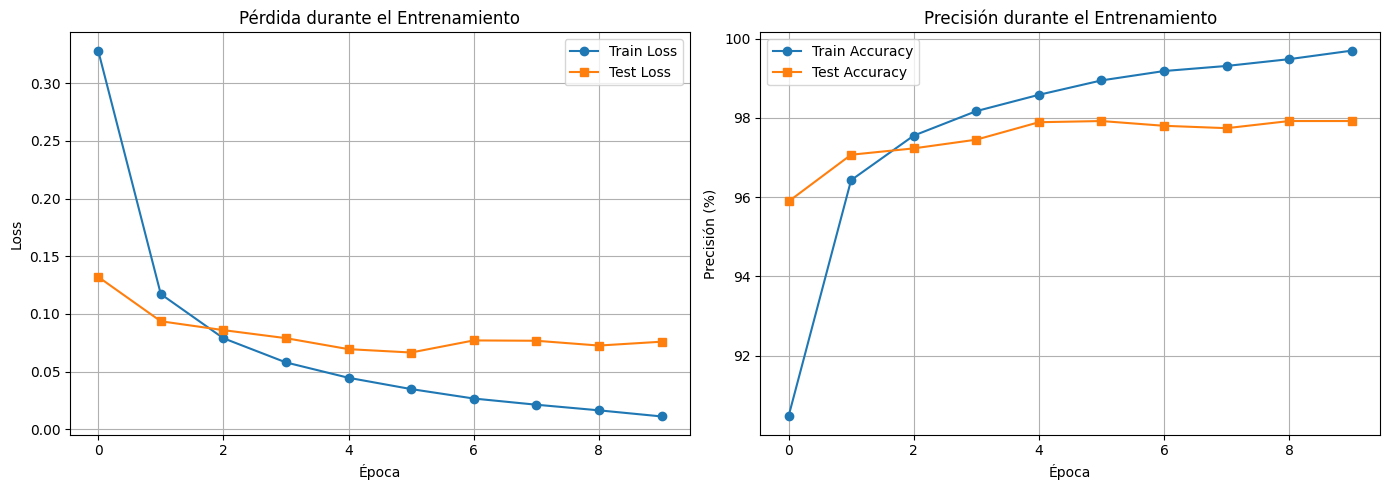

In [22]:
# Configuración del Ejercicio 9
batch_size = 64
learning_rate = 0.01  # SGD típicamente requiere un learning rate más alto
epochs = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = MLP(hidden_sizes=[128, 64], activation='relu').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)  # MODIFICADO

results_ex9 = run_experiment(model, train_loader, test_loader, criterion, optimizer, 
                             epochs, device, "Ejercicio 9: Optimizador SGD con Momentum")

### Respuestas Ejercicio 9

**9.1** ¿Cómo se compara la precisión final con el baseline (Adam)?

*Tu respuesta aquí*

**9.2** ¿Cuál optimizador converge más rápido?

*Tu respuesta aquí*

**9.3** ¿En qué escenarios preferirías usar SGD sobre Adam?

*Tu respuesta aquí*

---
## Ejercicio 10: Configuración Óptima

**Objetivo**: Combinar las mejores prácticas observadas en los ejercicios anteriores.

**Tarea**: Diseña tu propia configuración combinando los elementos que funcionaron mejor en los ejercicios anteriores. Justifica tus decisiones.

**Pregunta**: ¿Puedes obtener la mejor precisión posible combinando técnicas de regularización, arquitectura apropiada y buenos hiperparámetros?


Ejercicio 10: Configuración Óptima

Época [1/15] - Train Loss: 0.2665, Train Acc: 92.07% - Test Loss: 0.1483, Test Acc: 95.24%
Época [2/15] - Train Loss: 0.1095, Train Acc: 96.60% - Test Loss: 0.1039, Test Acc: 96.69%
Época [4/15] - Train Loss: 0.0581, Train Acc: 98.15% - Test Loss: 0.0815, Test Acc: 97.38%
Época [6/15] - Train Loss: 0.0401, Train Acc: 98.67% - Test Loss: 0.0889, Test Acc: 97.47%
Época [8/15] - Train Loss: 0.0288, Train Acc: 99.08% - Test Loss: 0.0843, Test Acc: 97.66%
Época [10/15] - Train Loss: 0.0241, Train Acc: 99.18% - Test Loss: 0.0929, Test Acc: 97.64%
Época [12/15] - Train Loss: 0.0172, Train Acc: 99.42% - Test Loss: 0.1003, Test Acc: 97.89%
Época [14/15] - Train Loss: 0.0152, Train Acc: 99.49% - Test Loss: 0.1003, Test Acc: 97.87%

Tiempo total de entrenamiento: 56.95 segundos
Precisión final en test: 97.33%


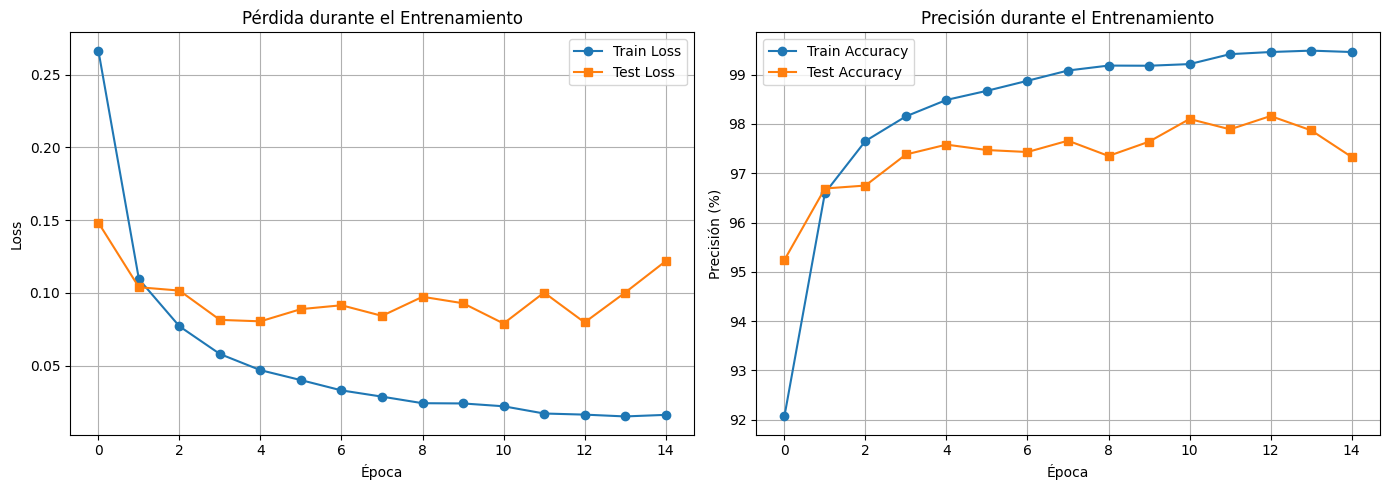

In [23]:
# Configuración del Ejercicio 10 - PERSONALÍZALO
# Modifica estos parámetros basándote en tus observaciones previas

batch_size = 64  # Modifica si es necesario
learning_rate = 0.001  # Modifica si es necesario
epochs = 15  # Puedes aumentar las épocas

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Personaliza la arquitectura y técnicas de regularización
model = MLP(
    hidden_sizes=[128, 64],  # Modifica la arquitectura
    activation='relu',  # Elige la mejor activación
    use_dropout=False,  # Activa si es necesario
    dropout_rate=0.5,
    use_batch_norm=False  # Activa si es necesario
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Elige el mejor optimizador

results_ex10 = run_experiment(model, train_loader, test_loader, criterion, optimizer, 
                              epochs, device, "Ejercicio 10: Configuración Óptima")

### Respuestas Ejercicio 10

**10.1** Describe la configuración que elegiste y justifica cada decisión:

- **Arquitectura elegida**: *Tu respuesta*
- **Learning rate**: *Tu respuesta*
- **Batch size**: *Tu respuesta*
- **Función de activación**: *Tu respuesta*
- **Técnicas de regularización**: *Tu respuesta*
- **Optimizador**: *Tu respuesta*

**10.2** ¿Cuál fue tu precisión final en test? ¿Es la mejor que lograste?

*Tu respuesta aquí*

**10.3** ¿Qué lecciones aprendiste sobre el ajuste de hiperparámetros?

*Tu respuesta aquí*

---
## Comparación Final

Ejecuta la siguiente celda para ver una comparación de todos tus experimentos:


COMPARACIÓN FINAL DE TODOS LOS EXPERIMENTOS
               Experimento Test Accuracy (%) Tiempo (s)
     Ejercicio 1: Baseline             97.47      37.35
      Ejercicio 2: LR Alto             96.47      42.65
 Ejercicio 3: Red Profunda             97.73      42.63
Ejercicio 4: Batch Pequeño             97.81      64.76
         Ejercicio 5: Tanh             97.10      38.52
      Ejercicio 6: Dropout             96.82      41.16
   Ejercicio 7: Batch Norm             98.04      39.00
    Ejercicio 8: Red Ancha             97.65      47.60
          Ejercicio 9: SGD             97.92      35.23
      Ejercicio 10: Óptima             97.33      56.95


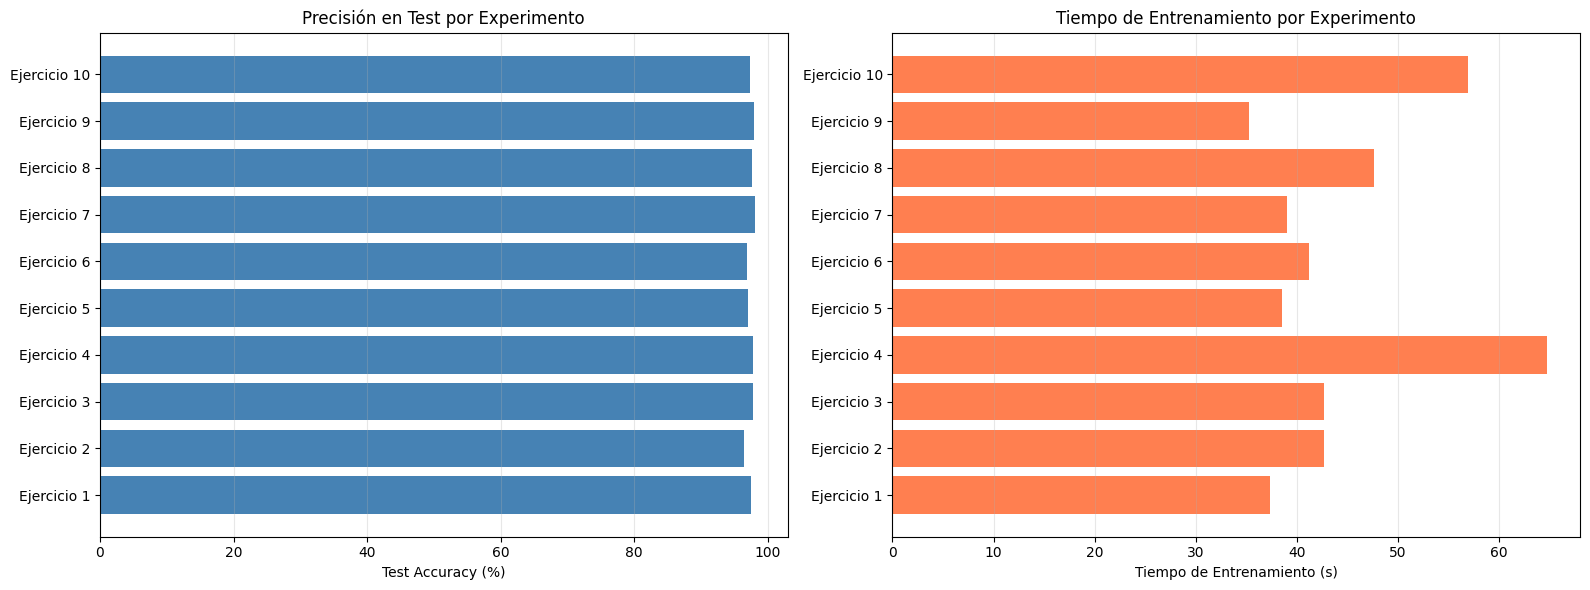

In [24]:
# Comparación de resultados de todos los ejercicios
import pandas as pd

# Recopila los resultados (asegúrate de haber ejecutado todos los ejercicios)
experiments = {
    'Ejercicio 1: Baseline': results_ex1,
    'Ejercicio 2: LR Alto': results_ex2,
    'Ejercicio 3: Red Profunda': results_ex3,
    'Ejercicio 4: Batch Pequeño': results_ex4,
    'Ejercicio 5: Tanh': results_ex5,
    'Ejercicio 6: Dropout': results_ex6,
    'Ejercicio 7: Batch Norm': results_ex7,
    'Ejercicio 8: Red Ancha': results_ex8,
    'Ejercicio 9: SGD': results_ex9,
    'Ejercicio 10: Óptima': results_ex10,
}

# Crear tabla comparativa
comparison_data = []
for name, result in experiments.items():
    comparison_data.append({
        'Experimento': name,
        'Test Accuracy (%)': f"{result['final_test_acc']:.2f}",
        'Tiempo (s)': f"{result['training_time']:.2f}"
    })

df_comparison = pd.DataFrame(comparison_data)
print("\n" + "="*70)
print("COMPARACIÓN FINAL DE TODOS LOS EXPERIMENTOS")
print("="*70)
print(df_comparison.to_string(index=False))
print("="*70)

# Visualización comparativa
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

experiment_names = [name.split(':')[0] for name in experiments.keys()]
accuracies = [result['final_test_acc'] for result in experiments.values()]
times = [result['training_time'] for result in experiments.values()]

ax1.barh(experiment_names, accuracies, color='steelblue')
ax1.set_xlabel('Test Accuracy (%)')
ax1.set_title('Precisión en Test por Experimento')
ax1.grid(axis='x', alpha=0.3)

ax2.barh(experiment_names, times, color='coral')
ax2.set_xlabel('Tiempo de Entrenamiento (s)')
ax2.set_title('Tiempo de Entrenamiento por Experimento')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

---
## Conclusiones Generales

**Reflexión Final**: Escribe un párrafo resumiendo las lecciones más importantes que aprendiste sobre:
- El impacto de los hiperparámetros en el rendimiento del modelo
- Las técnicas de regularización
- El diseño de arquitecturas de redes neuronales
- Los trade-offs entre complejidad y desempeño

*Tu reflexión aquí (mínimo 150 palabras)*